#Workshop Computer Vision 1

##Data Preparation

###Import Libraries and Initialize Dataset

In [64]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [65]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1y_H95k-2eeArxj-v_qoFy_yuegkhik6y' -O dataset.zip

--2025-04-21 12:35:26--  https://docs.google.com/uc?export=download&id=1y_H95k-2eeArxj-v_qoFy_yuegkhik6y
Resolving docs.google.com (docs.google.com)... 74.125.134.139, 74.125.134.113, 74.125.134.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.134.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1y_H95k-2eeArxj-v_qoFy_yuegkhik6y&export=download [following]
--2025-04-21 12:35:26--  https://drive.usercontent.google.com/download?id=1y_H95k-2eeArxj-v_qoFy_yuegkhik6y&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.212.132, 2607:f8b0:400c:c11::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.212.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17596191 (17M) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  16.78M  90.2MB/s    in

In [66]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: images/
   creating: images/George_W_Bush/
  inflating: images/George_W_Bush/1.jpg  
  inflating: images/George_W_Bush/10.jpg  
  inflating: images/George_W_Bush/2.jpg  
  inflating: images/George_W_Bush/3.jpg  
  inflating: images/George_W_Bush/4.jpg  
  inflating: images/George_W_Bush/5.jpg  
  inflating: images/George_W_Bush/6.jpg  
  inflating: images/George_W_Bush/7.jpg  
  inflating: images/George_W_Bush/8.jpg  
  inflating: images/George_W_Bush/9.jpg  
   creating: images/Laura_Bush/
  inflating: images/Laura_Bush/1.jpg  
  inflating: images/Laura_Bush/10.jpg  
  inflating: images/Laura_Bush/2.jpg  
  inflating: images/Laura_Bush/3.jpg  
  inflating: images/Laura_Bush/4.jpg  
  inflating: images/Laura_Bush/5.jpg  
  inflating: images/Laura_Bush/6.jpg  
  inflating: images/Laura_Bush/7.jpg  
  inflating: images/Laura_Bush/8.jpg  
  inflating: images/Laura_Bush/9.jpg  
   creating: images/Rama_Pratama/
  inflating: images/Rama_Pratama/17452371805

###Load Image and Labels

In [67]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print('Error: Could not load image.')
        return None, None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

dataset_dir = '/content/images'
images = []
labels = []

for root, dirs, files in os.walk(dataset_dir):
    if len(files) == 0:
        continue
    for f in files:
        _, image = load_image(os.path.join(root, f))
        if image is None:
            continue
        images.append(image)
        labels.append(root.split('/')[-1])


##Face Detection

###Load and Use the Haar Cascade Model

In [68]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [69]:
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
    faces = face_cascade.detectMultiScale(
        image_gray,
        scaleFactor=scale_factor,
        minNeighbors=min_neighbors,
        minSize=min_size
    )
    return faces

###Cropping faces

In [70]:
def crop_faces(image_gray, faces, return_all=False):
    cropped_faces = []
    selected_faces = []

    if len(faces) > 0:
        if return_all:
            for x, y, w, h in faces:
                selected_faces.append((x, y, w, h))
                cropped_faces.append(image_gray[y:y+h, x:x+w])
        else:
            x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
            selected_faces.append((x, y, w, h))
            cropped_faces.append(image_gray[y:y+h, x:x+w])

    return cropped_faces, selected_faces


##Face Recognition

###Resize and Flatten Faces

In [71]:
face_size = (128, 128)

def resize_and_flatten(face):
    face_resized = cv2.resize(face, face_size)
    face_flattened = face_resized.flatten()
    return face_flattened

###Prepare testing and training data

In [72]:
X = []
y = []

for image, label in zip(images, labels):
    faces = detect_faces(image)
    cropped_faces, _ = crop_faces(image, faces)

    if len(cropped_faces) > 0:
        face_flattened = resize_and_flatten(cropped_faces[0])
        X.append(face_flattened)
        y.append(label)

X = np.array(X)
y = np.array(y)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=177, stratify=y)

###Mean Centering

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanCentering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mean_face = np.mean(X, axis=0)
        return self

    def transform(self, X):
        return X - self.mean_face

###Extract Eigenfaces and Build Classifier

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

pipe = Pipeline([
    ('centering', MeanCentering()),
    ('pca', PCA(svd_solver='randomized', whiten=True, random_state=177)),
    ('svc', SVC(kernel='linear', random_state=177))
])

###Train and Evaluate Model

In [76]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

pipe = Pipeline([
    ('centering', MeanCentering()),
    ('pca', PCA(svd_solver='randomized', whiten=True, random_state=177)),
    ('svc', SVC(kernel='linear', random_state=177))
])


###Visualizing Eigenfaces

In [77]:
from sklearn.metrics import classification_report

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

     George_W_Bush       0.67      0.67      0.67         3
        Laura_Bush       0.50      0.67      0.57         3
      Rama_Pratama       0.50      0.33      0.40         3
Scarlett_Johansson       1.00      0.33      0.50         3
   Serena_Williams       0.67      0.67      0.67         3
    Vladimir_Putin       0.25      0.33      0.29         3
   Windah_Basudara       0.50      0.67      0.57         3

          accuracy                           0.52        21
         macro avg       0.58      0.52      0.52        21
      weighted avg       0.58      0.52      0.52        21



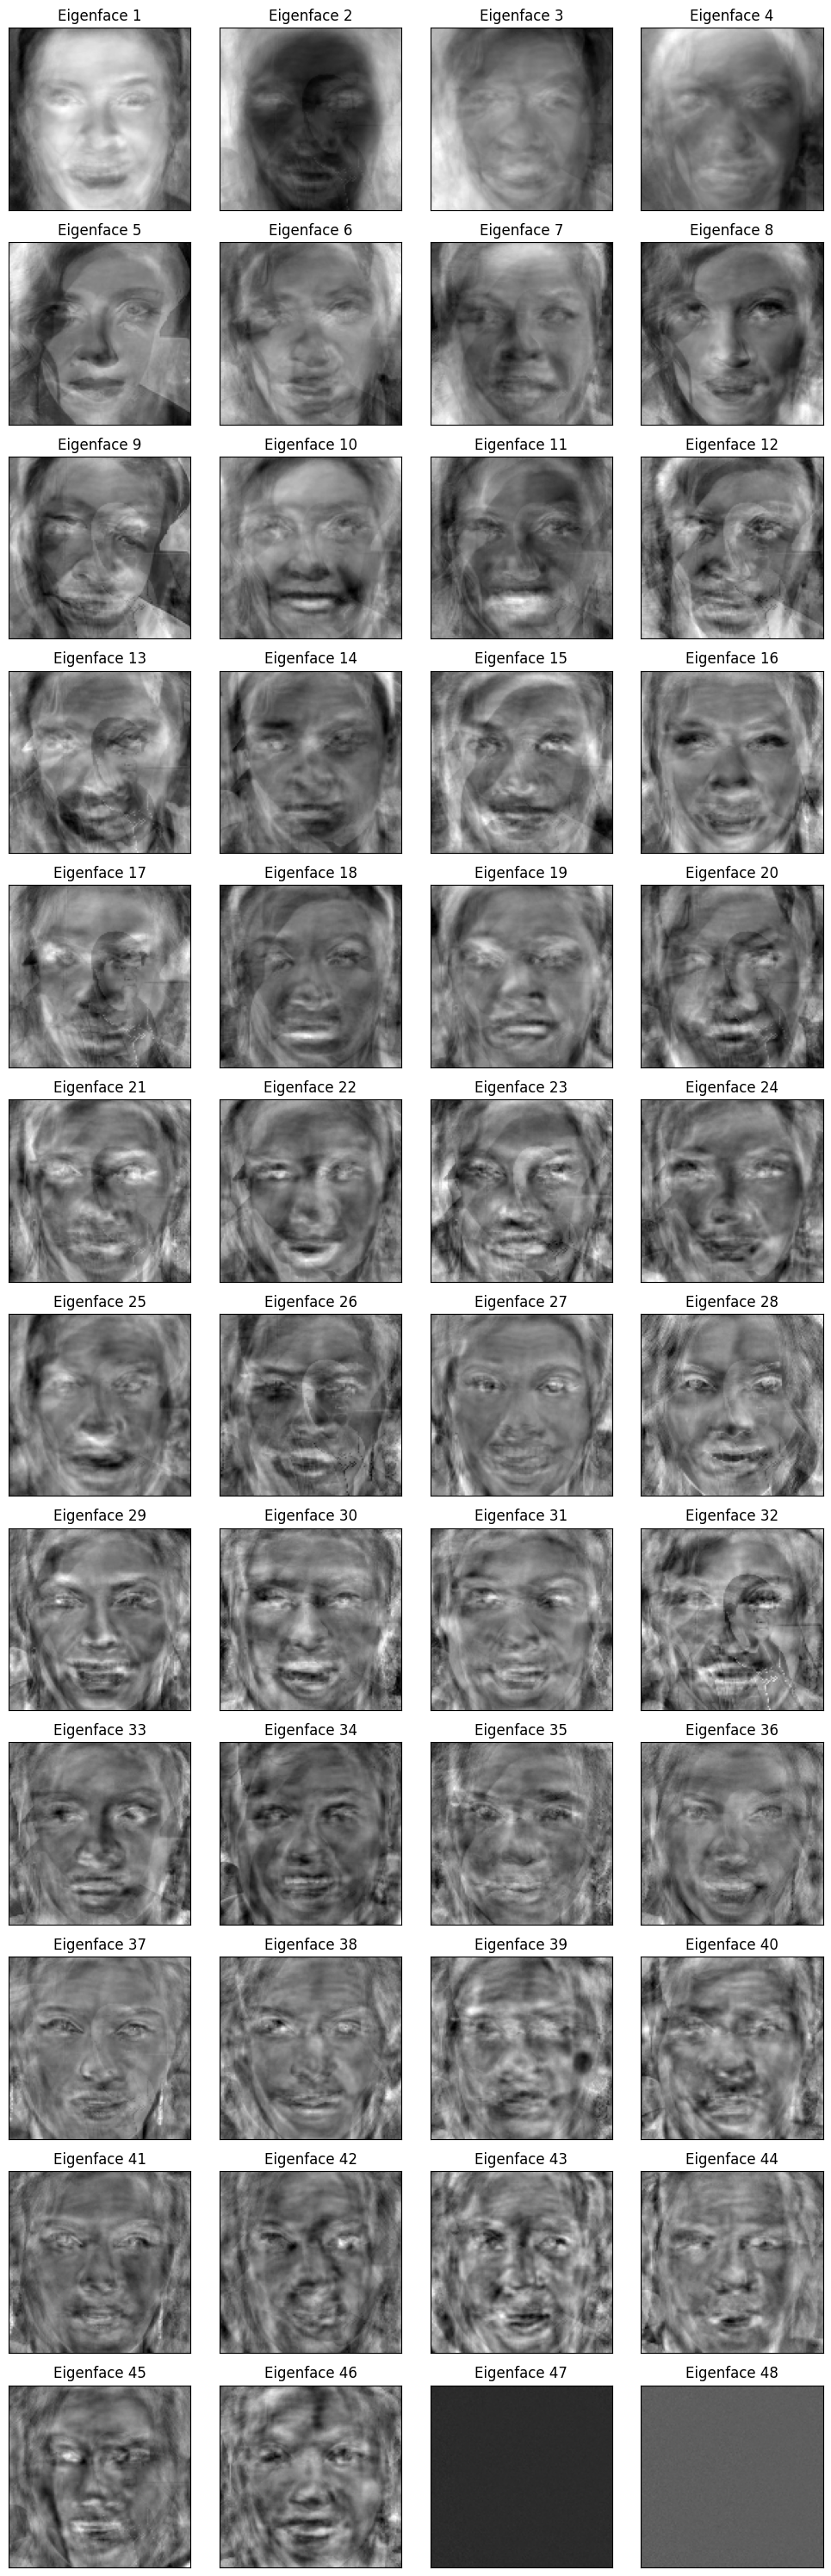

In [78]:
n_components = len(pipe[1].components_)
ncol = 4
nrow = (n_components + ncol - 1) // ncol

fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5 * nrow),
                         subplot_kw={'xticks': [], 'yticks': []})

eigenfaces = pipe[1].components_.reshape((n_components, X_train.shape[1]))

for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
    ax.set_title(f'Eigenface {i+1}')

plt.tight_layout()
plt.show()

###Save model pipeline

In [79]:
import pickle

with open('eigenface_pipeline.pkl', 'wb') as f:
    pickle.dump(pipe, f)

###Combine all methods

In [80]:
def get_eigenface_score(X):
    X_pca = pipe[:2].transform(X)
    eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1)
    return eigenface_scores


In [81]:
def eigenface_prediction(image_gray):
    faces = detect_faces(image_gray)
    cropped_faces, selected_faces = crop_faces(image_gray, faces)

    if len(cropped_faces) == 0:
        return 'No face detected.'

    X_face = []
    for face in cropped_faces:
        face_flattened = resize_and_flatten(face)
        X_face.append(face_flattened)

    X_face = np.array(X_face)
    labels = pipe.predict(X_face)
    scores = get_eigenface_score(X_face)

    return scores, labels, selected_faces

###Visualizes result

In [82]:
def draw_text(image, label, score,
              font=cv2.FONT_HERSHEY_SIMPLEX,
              pos=(0, 0),
              font_scale=0.6,
              font_thickness=2,
              text_color=(0, 0, 0),
              text_color_bg=(0, 255, 0)):
    x, y = pos
    score_text = f'Score: {score:.2f}'

    (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, font_thickness)
    (w2, h2), _ = cv2.getTextSize(label, font, font_scale, font_thickness)

    cv2.rectangle(image, (x, y - h1 - h2 - 25), (x + max(w1, w2) + 20, y), text_color_bg, -1)
    cv2.putText(image, label, (x + 10, y - 10), font, font_scale, text_color, font_thickness)
    cv2.putText(image, score_text, (x + 10, y - h2 - 15), font, font_scale, text_color, font_thickness)

In [83]:
def draw_result(image, scores, labels, coords):
    result_image = image.copy()

    for (x, y, w, h), label, score in zip(coords, labels, scores):
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        draw_text(result_image, label, score, pos=(x, y))

    return result_image


##Image Test

Predicted labels: ['Rama_Pratama']
Confidence scores: [6.33333333]


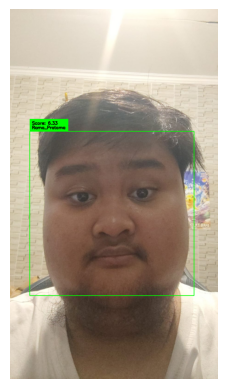

In [85]:
image_path = "test.jpg"
image, image_gray = load_image(image_path)  # Get both color & gray images
result = eigenface_prediction(image_gray)

if isinstance(result, str):
    print(result)  # "No face detected."
else:
    scores, labels, coords = result
    print("Predicted labels:", labels)
    print("Confidence scores:", scores)

    # Use the original BGR image instead of grayscale
    result_image = draw_result(image, scores, labels, coords)

    # Convert BGR to RGB for proper plt display
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
